In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = 25, 10

# Load and prepare data 

In [3]:
!head ./train.csv

In [4]:
# Test.csv has only inputs, not outputs, it's used by Kaggle to measure participants. 
# So we can't use the data at test.csv to test our predictions

all_data = pd.read_csv('./train.csv')

BETTER_COLUMN_NAMES = {
    'PassengerId': 'passenger_id',
    'Survived': 'survived',
    'Pclass': 'ticket_class',
    'Name': 'name',
    'Sex': 'sex',
    'Age': 'age',
    'SibSp': 'siblings_spouses',
    'Parch': 'parents_children',
    'Ticket': 'ticket',
    'Fare': 'fare',
    'Cabin': 'cabin',
    'Embarked': 'embarked_at',
    'Survived': 'survived',
}
all_data.rename(columns=BETTER_COLUMN_NAMES, inplace=True)

all_data.set_index('passenger_id', inplace=True)

all_data.shape

(891, 11)

In [5]:
all_data['age'].fillna(all_data.age.mean(), inplace=True)  # fill unknown ages with an average
all_data['embarked_at'].fillna('U', inplace=True)  # fill unknown embark locations with 'U' (from Unknown)

In [6]:
all_data

,survived,ticket_class,name,sex,age,siblings_spouses,parents_children,ticket,fare,cabin,embarked_at
passenger_id,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,NaN,S


## Output column will be:

- survived

## We will use as inputs:

- sex: male/female
- age: numbers, many NaNs
- siblings_spouses: numbers, no NaNs
- parents_children: numbers, no NaNs
- ticket_class: 1/2/3
- fare: numbers, no NaNs
- embarked_at: C/Q/S and very few NaNs

## We won't use as inputs:

- passenger_id: this could only lead to overfitting
- name: this has a high change of leading to overfitting
- cabin: very little data, and maybe able to overfit? are these single family/person rooms?



In [7]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(all_data, test_size=0.4)
validation, test = train_test_split(not_train, test_size=0.5)

In [8]:
def evaluate_model(model, extract_inputs_function, extract_outputs_function, include_validation=False):
    sets = [('train', train), ('test', test)]
    if include_validation:
        sets.append(('validation', validation))
        
    for set_name, set_data in sets:
        inputs = extract_inputs_function(set_data)
        outputs = extract_outputs_function(set_data)
        predictions = model.predict(inputs)
        
        print(set_name, '#' * 80)
        
        # print metrics
        
        print('Accuracy:', accuracy_score(outputs, predictions))
        print('Precision:', precision_score(outputs, predictions))
        print('Recall:', recall_score(outputs, predictions))
        print()
        
        # plot confussion matrix
        
        plt.figure(figsize=(3,4))
        
        plt.xticks([0, 1], ['died', 'survived'], rotation=45)
        plt.yticks([0, 1], ['died', 'survived'])
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.title(set_name)

        plt.imshow(
            confusion_matrix(outputs, predictions), 
            cmap=plt.cm.Blues, 
            interpolation='nearest',
        )

        plt.show()

# First model: logistic regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [10]:
# final input columns, in the order we want to use them
LR_INPUT_COLUMNS = [
    'sex_m',
    'sex_f',
    'age',
    'siblings_spouses',
    'parents_children',
    'ticket_class',
    'fare',
    'embarked_at_c',
    'embarked_at_q',
    'embarked_at_s',
]


def lr_extract_inputs(dataset):
    """
    Inputs in the format supported by the logistic regressor.
    """
    # we don't want to modify the original dataset, that we will use with other models
    inputs = dataset.copy()
    
    # sex to numbers
    inputs['sex_m'] = inputs.sex == 'male'
    inputs['sex_f'] = inputs.sex == 'female'
    del inputs['sex']
    
    # embarked at to numbers
    inputs['embarked_at_c'] = inputs.embarked_at == 'C'
    inputs['embarked_at_q'] = inputs.embarked_at == 'Q'
    inputs['embarked_at_s'] = inputs.embarked_at == 'S'
    del inputs['embarked_at']
    
    # return the raw numbers
    return inputs[LR_INPUT_COLUMNS].values.astype(np.float64)

def lr_extract_outputs(dataset):
    """
    Outputs in the format supported by the logistic regressor.
    """
    return dataset.survived.values

In [11]:
lr_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression()),
])

In [12]:
lr_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

train ################################################################################
Accuracy: 0.8071161048689138
Precision: 0.7567567567567568
Recall: 0.7070707070707071



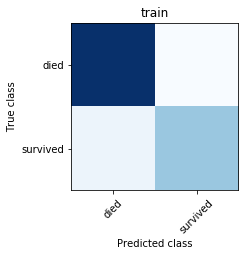

test ################################################################################
Accuracy: 0.776536312849162
Precision: 0.7586206896551724
Recall: 0.6285714285714286



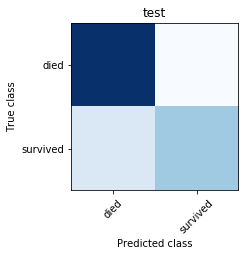

In [13]:
evaluate_model(lr_model, lr_extract_inputs, lr_extract_outputs)

In [14]:
lr_model.steps

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('classifier',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False))]

In [15]:
clf = lr_model.steps[1][1]
clf.coef_

array([[-0.69741802,  0.69741802, -0.41112852, -0.18214891, -0.25148712,
        -0.84902098,  0.05035918,  0.14552443, -0.0694938 , -0.21213351]])

In [16]:
for col_name, weight in zip(LR_INPUT_COLUMNS, clf.coef_[0]):
    print(col_name, ':', weight)

sex_m : -0.6974180222618602
sex_f : 0.6974180222618602
age : -0.411128523558671
siblings_spouses : -0.18214890600535888
parents_children : -0.2514871174032177
ticket_class : -0.849020978076828
fare : 0.050359180906591694
embarked_at_c : 0.14552442796786305
embarked_at_q : -0.06949380101497137
embarked_at_s : -0.21213351193708757


# Second model: K nearest neighbors

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
K = 10

knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

In [19]:
knn_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform'))])

train ################################################################################
Accuracy: 0.8352059925093633
Precision: 0.8571428571428571
Recall: 0.6666666666666666



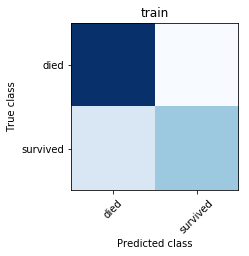

test ################################################################################
Accuracy: 0.8100558659217877
Precision: 0.8214285714285714
Recall: 0.6571428571428571



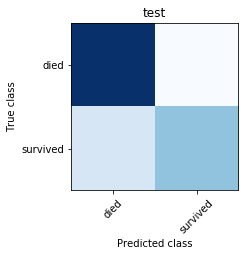

In [20]:
evaluate_model(knn_model, lr_extract_inputs, lr_extract_outputs)

# Third model: Decision Trees

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
# final input columns, in the order we want to use them
TREE_INPUT_COLUMNS = [
    'sex',
    'age',
    'siblings_spouses',
    'parents_children',
    'ticket_class',
    'fare',
    'embarked_at',
]


def tree_extract_inputs(dataset):
    """
    Inputs in the format supported by the logistic regressor.
    """
    # we don't want to modify the original dataset, that we will use with other models
    inputs = dataset.copy()
    
    # sex to labels
    inputs['sex'] = inputs.sex.map({'male': 1, 'female': 2})

    # embarked_at to labels
    inputs['embarked_at'] = inputs.embarked_at.map({'C': 1, 'Q': 2, 'S': 3, 'U': 4})
    
    # return the raw numbers
    return inputs[TREE_INPUT_COLUMNS].values

def tree_extract_outputs(dataset):
    """
    Outputs in the format supported by the logistic regressor.
    """
    return dataset.survived.values

In [23]:
tree_model = DecisionTreeClassifier()
# max_depth=3?

In [24]:
tree_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

train ################################################################################
Accuracy: 0.9887640449438202
Precision: 0.9948453608247423
Recall: 0.9747474747474747



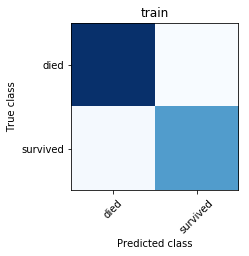

test ################################################################################
Accuracy: 0.7988826815642458
Precision: 0.7428571428571429
Recall: 0.7428571428571429



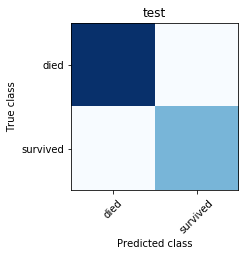

In [25]:
evaluate_model(tree_model, tree_extract_inputs, tree_extract_outputs)

In [26]:
import graphviz  # pip install graphviz
from sklearn.tree import export_graphviz

def graph_tree(tree):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=TREE_INPUT_COLUMNS,  
        class_names=['died', 'survived'],  
        filled=True, 
        rounded=True,  
        special_characters=True,
    )
    graph = graphviz.Source(graph_data)  
    # graph.render('rendered_tree')
    return graph

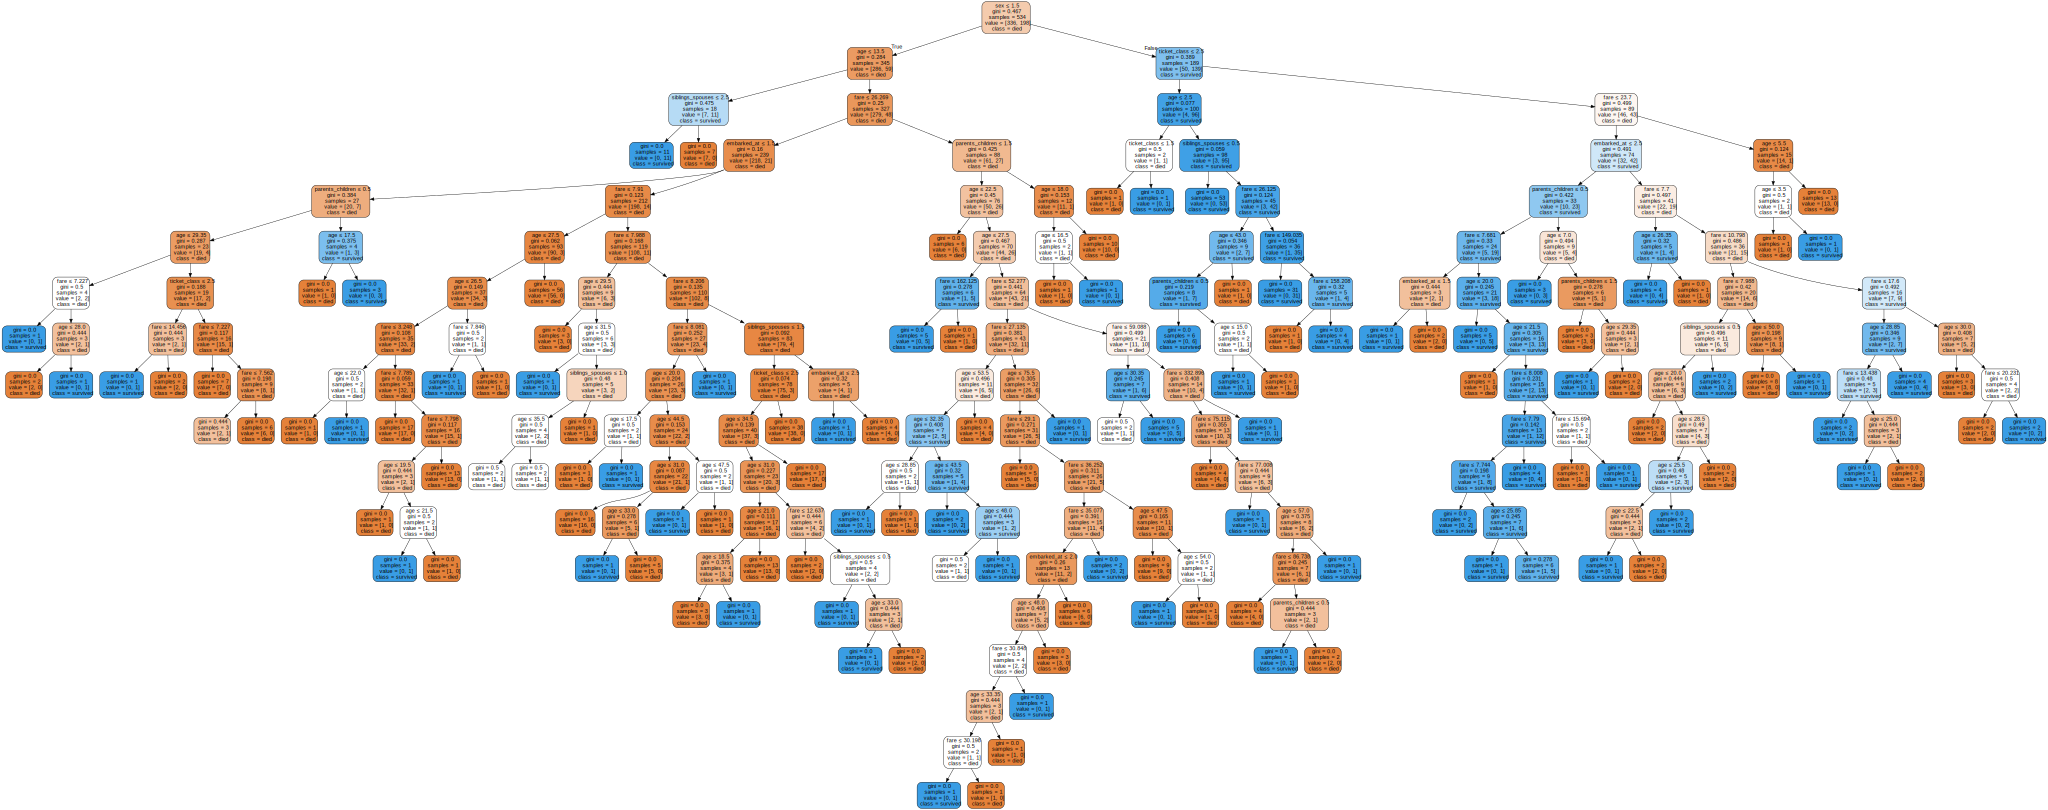

In [27]:
graph_tree(tree_model)

# Fourth model: Random Forests

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
forest_model = RandomForestClassifier()
# n_estimators? max_depth=3?, max_features=2?

In [30]:
forest_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

train ################################################################################
Accuracy: 0.9662921348314607
Precision: 0.9787234042553191
Recall: 0.9292929292929293



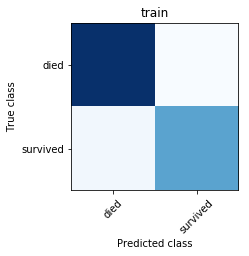

test ################################################################################
Accuracy: 0.7932960893854749
Precision: 0.7796610169491526
Recall: 0.6571428571428571



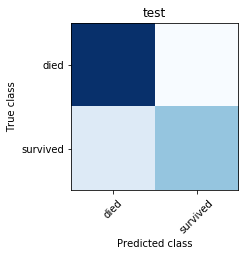

In [31]:
evaluate_model(forest_model, tree_extract_inputs, tree_extract_outputs)

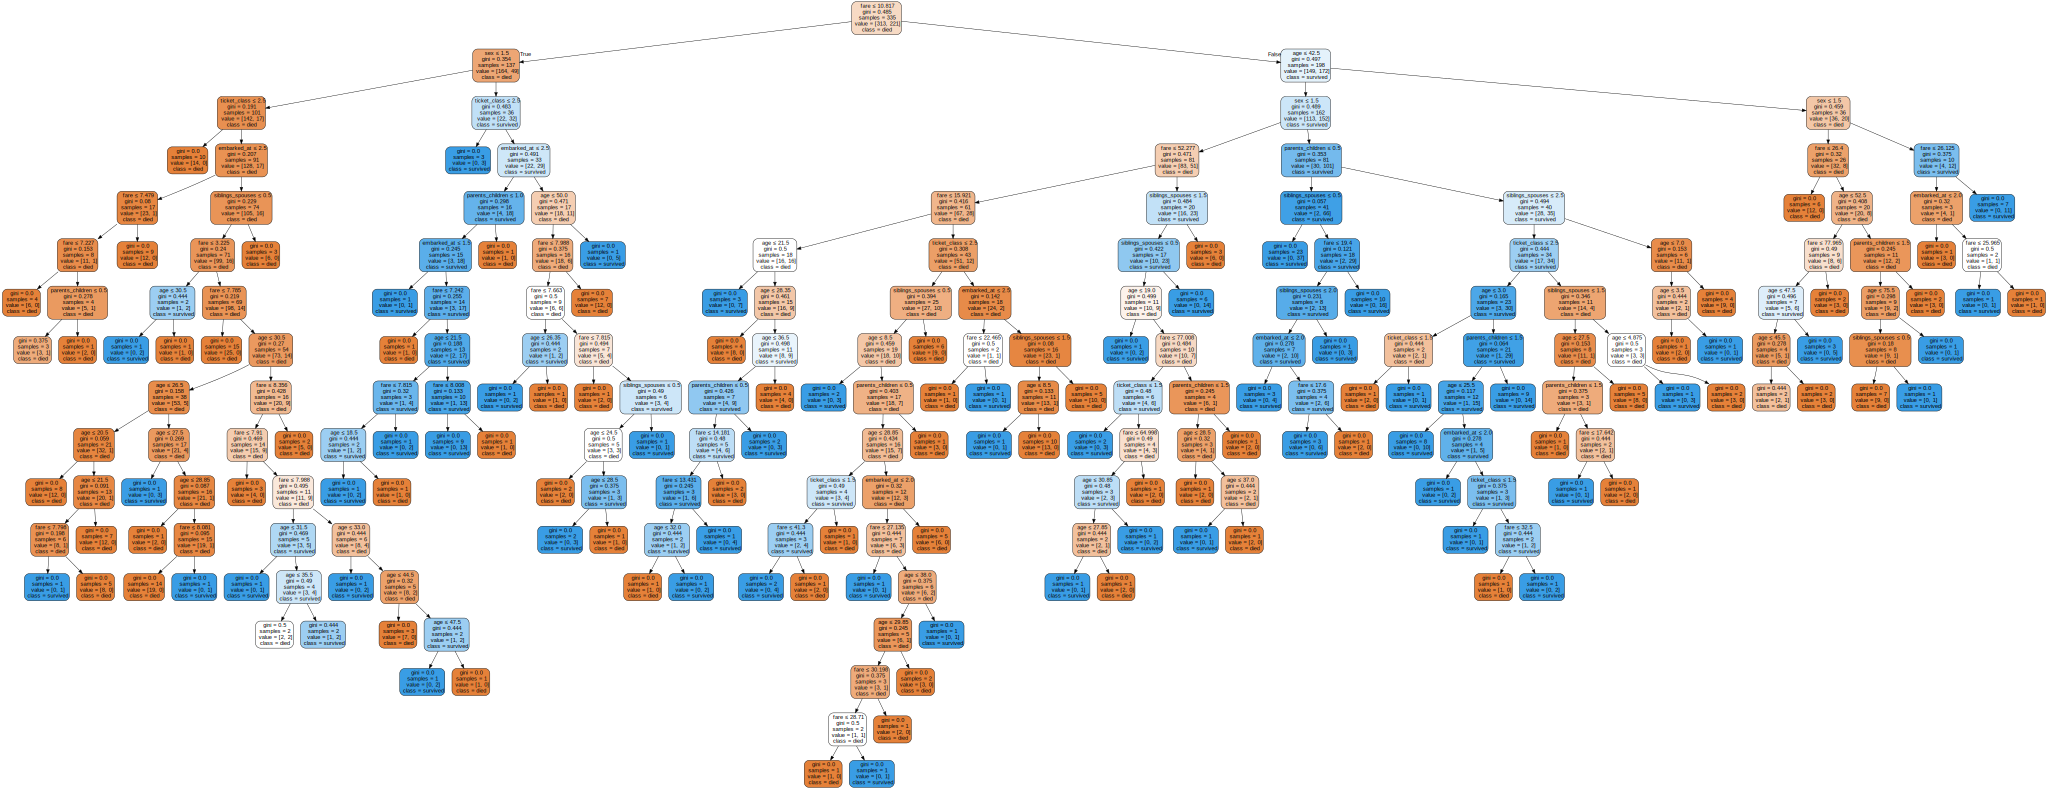

In [32]:
graph_tree(forest_model.estimators_[0])

# Fifth model: Gradient Boosted Trees

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

In [34]:
boost_model = GradientBoostingClassifier()

In [35]:
boost_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

train ################################################################################
Accuracy: 0.9063670411985019
Precision: 0.9252873563218391
Recall: 0.8131313131313131



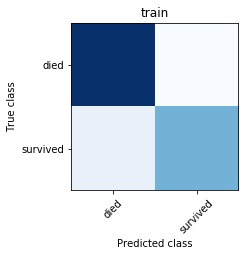

test ################################################################################
Accuracy: 0.8100558659217877
Precision: 0.8
Recall: 0.6857142857142857



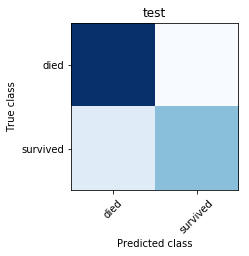

In [36]:
evaluate_model(boost_model, tree_extract_inputs, tree_extract_outputs)

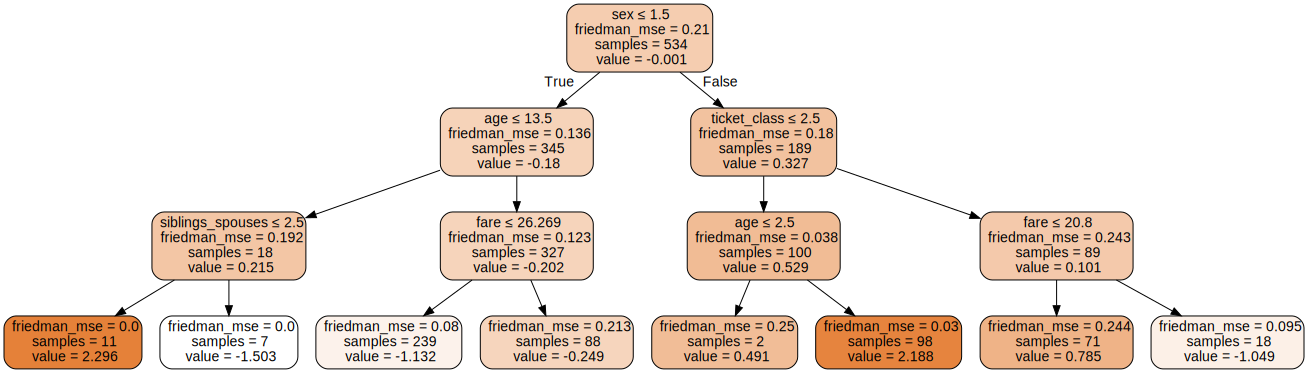

In [37]:
graph_tree(boost_model.estimators_[1][0])

# Sixth model: Neural Networks

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout

/home/fisa/venvs/ds/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [39]:
nn_model = Sequential([   
    Dense(100, input_shape=(len(LR_INPUT_COLUMNS), )),
    Activation('tanh'),
    
    # Dropout(0.1),

    Dense(100),
    Activation('tanh'),
    
    # Dropout(0.1),

    Dense(1),
    Activation('sigmoid'),
])

nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [40]:
history = nn_model.fit(
    lr_extract_inputs(train), 
    lr_extract_outputs(train),
    epochs=500,
    batch_size=128,
    validation_data=(
        lr_extract_inputs(test),
        lr_extract_outputs(test),
    )
)

Train on 534 samples, validate on 179 samples
Epoch 1/500
534/534 [==============================] - 1s 2ms/step - loss: 0.6798 - acc: 0.6049 - val_loss: 0.6254 - val_acc: 0.6816
Epoch 2/500
534/534 [==============================] - 0s 29us/step - loss: 0.6257 - acc: 0.6891 - val_loss: 0.6283 - val_acc: 0.6648
Epoch 3/500
534/534 [==============================] - 0s 22us/step - loss: 0.6151 - acc: 0.6685 - val_loss: 0.5938 - val_acc: 0.6760
Epoch 4/500
534/534 [==============================] - 0s 25us/step - loss: 0.5905 - acc: 0.6816 - val_loss: 0.5918 - val_acc: 0.6816
Epoch 5/500
534/534 [==============================] - 0s 20us/step - loss: 0.5856 - acc: 0.7022 - val_loss: 0.5754 - val_acc: 0.7095
Epoch 6/500
534/534 [==============================] - 0s 23us/step - loss: 0.5725 - acc: 0.7041 - val_loss: 0.5704 - val_acc: 0.6760
Epoch 7/500
534/534 [==============================] - 0s 18us/step - loss: 0.5661 - acc: 0.7004 - val_loss: 0.5634 - val_acc: 0.7207
Epoch 8/500
534/5

534/534 [==============================] - 0s 21us/step - loss: 0.3801 - acc: 0.8502 - val_loss: 0.4580 - val_acc: 0.7989
Epoch 62/500
534/534 [==============================] - 0s 22us/step - loss: 0.3812 - acc: 0.8427 - val_loss: 0.4637 - val_acc: 0.7709
Epoch 63/500
534/534 [==============================] - 0s 20us/step - loss: 0.3735 - acc: 0.8464 - val_loss: 0.4590 - val_acc: 0.7933
Epoch 64/500
534/534 [==============================] - 0s 18us/step - loss: 0.3758 - acc: 0.8408 - val_loss: 0.4613 - val_acc: 0.7989
Epoch 65/500
534/534 [==============================] - 0s 25us/step - loss: 0.3695 - acc: 0.8427 - val_loss: 0.4555 - val_acc: 0.7933
Epoch 66/500
534/534 [==============================] - 0s 20us/step - loss: 0.3771 - acc: 0.8333 - val_loss: 0.4575 - val_acc: 0.7933
Epoch 67/500
534/534 [==============================] - 0s 25us/step - loss: 0.3727 - acc: 0.8315 - val_loss: 0.4587 - val_acc: 0.7877
Epoch 68/500
534/534 [==============================] - 0s 20us/step

534/534 [==============================] - 0s 19us/step - loss: 0.3420 - acc: 0.8539 - val_loss: 0.4703 - val_acc: 0.7765
Epoch 122/500
534/534 [==============================] - 0s 20us/step - loss: 0.3381 - acc: 0.8558 - val_loss: 0.4754 - val_acc: 0.7765
Epoch 123/500
534/534 [==============================] - 0s 18us/step - loss: 0.3406 - acc: 0.8464 - val_loss: 0.4850 - val_acc: 0.7709
Epoch 124/500
534/534 [==============================] - 0s 18us/step - loss: 0.3444 - acc: 0.8521 - val_loss: 0.4803 - val_acc: 0.7709
Epoch 125/500
534/534 [==============================] - 0s 20us/step - loss: 0.3393 - acc: 0.8596 - val_loss: 0.4799 - val_acc: 0.7709
Epoch 126/500
534/534 [==============================] - 0s 19us/step - loss: 0.3434 - acc: 0.8483 - val_loss: 0.4800 - val_acc: 0.7765
Epoch 127/500
534/534 [==============================] - 0s 20us/step - loss: 0.3390 - acc: 0.8539 - val_loss: 0.4764 - val_acc: 0.7821
Epoch 128/500
534/534 [==============================] - 0s 20

534/534 [==============================] - 0s 22us/step - loss: 0.3197 - acc: 0.8633 - val_loss: 0.4997 - val_acc: 0.7709
Epoch 182/500
534/534 [==============================] - 0s 22us/step - loss: 0.3374 - acc: 0.8558 - val_loss: 0.4836 - val_acc: 0.7598
Epoch 183/500
534/534 [==============================] - 0s 21us/step - loss: 0.3158 - acc: 0.8670 - val_loss: 0.4841 - val_acc: 0.7542
Epoch 184/500
534/534 [==============================] - 0s 19us/step - loss: 0.3210 - acc: 0.8596 - val_loss: 0.4891 - val_acc: 0.7709
Epoch 185/500
534/534 [==============================] - 0s 22us/step - loss: 0.3201 - acc: 0.8633 - val_loss: 0.4894 - val_acc: 0.7542
Epoch 186/500
534/534 [==============================] - 0s 21us/step - loss: 0.3277 - acc: 0.8502 - val_loss: 0.4950 - val_acc: 0.7765
Epoch 187/500
534/534 [==============================] - 0s 23us/step - loss: 0.3288 - acc: 0.8614 - val_loss: 0.4943 - val_acc: 0.7654
Epoch 188/500
534/534 [==============================] - 0s 18

534/534 [==============================] - 0s 21us/step - loss: 0.3200 - acc: 0.8483 - val_loss: 0.5026 - val_acc: 0.7430
Epoch 242/500
534/534 [==============================] - 0s 20us/step - loss: 0.3045 - acc: 0.8764 - val_loss: 0.5071 - val_acc: 0.7598
Epoch 243/500
534/534 [==============================] - 0s 23us/step - loss: 0.3054 - acc: 0.8820 - val_loss: 0.5016 - val_acc: 0.7598
Epoch 244/500
534/534 [==============================] - 0s 25us/step - loss: 0.3019 - acc: 0.8764 - val_loss: 0.5027 - val_acc: 0.7542
Epoch 245/500
534/534 [==============================] - 0s 23us/step - loss: 0.3105 - acc: 0.8689 - val_loss: 0.5028 - val_acc: 0.7486
Epoch 246/500
534/534 [==============================] - 0s 26us/step - loss: 0.3188 - acc: 0.8596 - val_loss: 0.5079 - val_acc: 0.7765
Epoch 247/500
534/534 [==============================] - 0s 23us/step - loss: 0.3076 - acc: 0.8820 - val_loss: 0.5088 - val_acc: 0.7654
Epoch 248/500
534/534 [==============================] - 0s 20

534/534 [==============================] - 0s 25us/step - loss: 0.2928 - acc: 0.8858 - val_loss: 0.5173 - val_acc: 0.7598
Epoch 302/500
534/534 [==============================] - 0s 18us/step - loss: 0.2911 - acc: 0.8895 - val_loss: 0.5158 - val_acc: 0.7598
Epoch 303/500
534/534 [==============================] - 0s 19us/step - loss: 0.2963 - acc: 0.8727 - val_loss: 0.5250 - val_acc: 0.7598
Epoch 304/500
534/534 [==============================] - 0s 22us/step - loss: 0.3041 - acc: 0.8708 - val_loss: 0.5267 - val_acc: 0.7709
Epoch 305/500
534/534 [==============================] - 0s 21us/step - loss: 0.2976 - acc: 0.8764 - val_loss: 0.5271 - val_acc: 0.7709
Epoch 306/500
534/534 [==============================] - 0s 21us/step - loss: 0.2917 - acc: 0.8820 - val_loss: 0.5170 - val_acc: 0.7598
Epoch 307/500
534/534 [==============================] - 0s 22us/step - loss: 0.3054 - acc: 0.8745 - val_loss: 0.5212 - val_acc: 0.7765
Epoch 308/500
534/534 [==============================] - 0s 22

534/534 [==============================] - 0s 20us/step - loss: 0.2806 - acc: 0.8876 - val_loss: 0.5298 - val_acc: 0.7709
Epoch 362/500
534/534 [==============================] - 0s 22us/step - loss: 0.2827 - acc: 0.8820 - val_loss: 0.5302 - val_acc: 0.7654
Epoch 363/500
534/534 [==============================] - 0s 21us/step - loss: 0.2774 - acc: 0.8933 - val_loss: 0.5392 - val_acc: 0.7598
Epoch 364/500
534/534 [==============================] - 0s 18us/step - loss: 0.2899 - acc: 0.8801 - val_loss: 0.5362 - val_acc: 0.7654
Epoch 365/500
534/534 [==============================] - 0s 19us/step - loss: 0.2862 - acc: 0.8858 - val_loss: 0.5383 - val_acc: 0.7542
Epoch 366/500
534/534 [==============================] - 0s 25us/step - loss: 0.2847 - acc: 0.8801 - val_loss: 0.5308 - val_acc: 0.7598
Epoch 367/500
534/534 [==============================] - 0s 19us/step - loss: 0.2780 - acc: 0.8933 - val_loss: 0.5252 - val_acc: 0.7542
Epoch 368/500
534/534 [==============================] - 0s 18

534/534 [==============================] - 0s 25us/step - loss: 0.2687 - acc: 0.8970 - val_loss: 0.5356 - val_acc: 0.7654
Epoch 422/500
534/534 [==============================] - 0s 20us/step - loss: 0.2716 - acc: 0.9026 - val_loss: 0.5446 - val_acc: 0.7709
Epoch 423/500
534/534 [==============================] - 0s 18us/step - loss: 0.2748 - acc: 0.8783 - val_loss: 0.5421 - val_acc: 0.7709
Epoch 424/500
534/534 [==============================] - 0s 23us/step - loss: 0.2871 - acc: 0.8764 - val_loss: 0.5443 - val_acc: 0.7654
Epoch 425/500
534/534 [==============================] - 0s 20us/step - loss: 0.2730 - acc: 0.8989 - val_loss: 0.5475 - val_acc: 0.7709
Epoch 426/500
534/534 [==============================] - 0s 20us/step - loss: 0.2743 - acc: 0.8839 - val_loss: 0.5446 - val_acc: 0.7598
Epoch 427/500
534/534 [==============================] - 0s 25us/step - loss: 0.2680 - acc: 0.8895 - val_loss: 0.5499 - val_acc: 0.7709
Epoch 428/500
534/534 [==============================] - 0s 20

534/534 [==============================] - 0s 24us/step - loss: 0.2637 - acc: 0.9007 - val_loss: 0.5341 - val_acc: 0.7598
Epoch 482/500
534/534 [==============================] - 0s 18us/step - loss: 0.2743 - acc: 0.8858 - val_loss: 0.5394 - val_acc: 0.7542
Epoch 483/500
534/534 [==============================] - 0s 20us/step - loss: 0.2708 - acc: 0.8970 - val_loss: 0.5409 - val_acc: 0.7654
Epoch 484/500
534/534 [==============================] - 0s 19us/step - loss: 0.2841 - acc: 0.8858 - val_loss: 0.5457 - val_acc: 0.7709
Epoch 485/500
534/534 [==============================] - 0s 18us/step - loss: 0.2672 - acc: 0.9082 - val_loss: 0.5601 - val_acc: 0.7765
Epoch 486/500
534/534 [==============================] - 0s 19us/step - loss: 0.2719 - acc: 0.8858 - val_loss: 0.5576 - val_acc: 0.7654
Epoch 487/500
534/534 [==============================] - 0s 21us/step - loss: 0.2758 - acc: 0.8839 - val_loss: 0.5593 - val_acc: 0.7598
Epoch 488/500
534/534 [==============================] - 0s 20

train ################################################################################
Accuracy: 0.8352059925093633
Precision: 0.8571428571428571
Recall: 0.6666666666666666



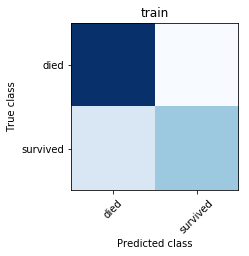

test ################################################################################
Accuracy: 0.8100558659217877
Precision: 0.8214285714285714
Recall: 0.6571428571428571



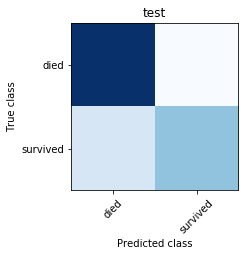

In [41]:
evaluate_model(knn_model, lr_extract_inputs, lr_extract_outputs)

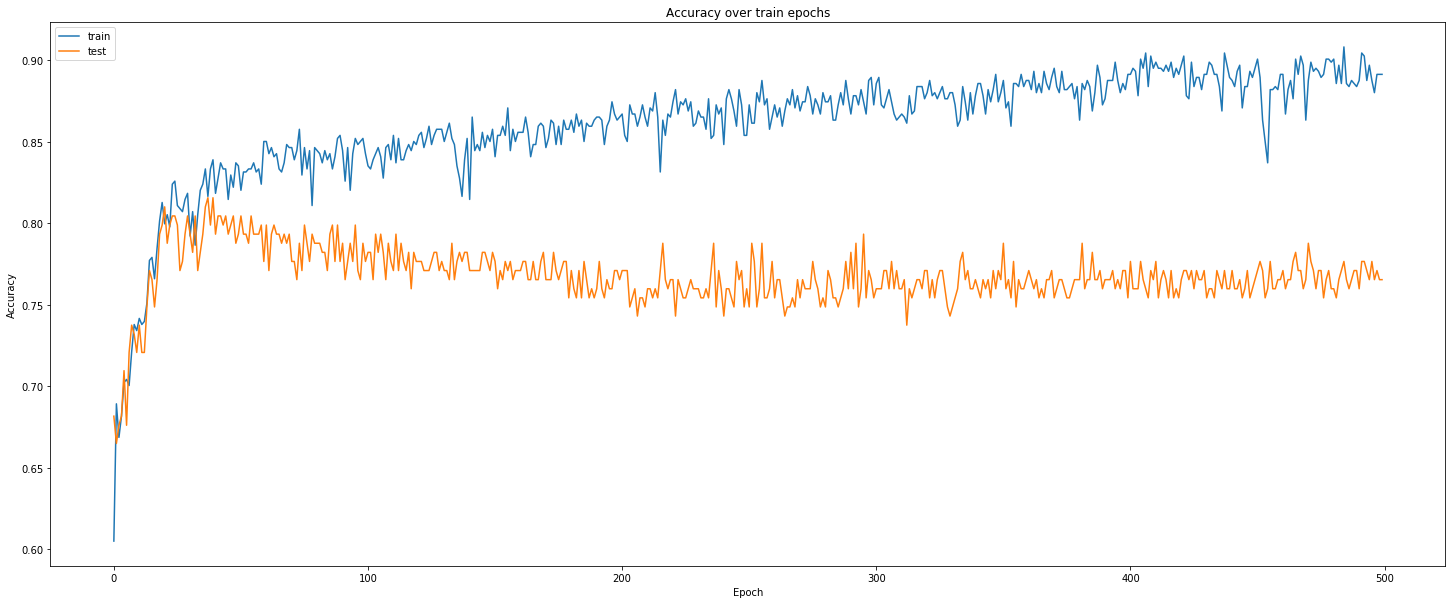

In [42]:
# plot accuracy over training epochs
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()